## importing the data and installing necessary libraries

In [1]:
# !pip install tensorflow-hub
# !pip install sentencepiece
# !pip install tensorflow



In [2]:
import tensorflow as tf
import tensorflow_hub as hub
print("TF version: ", tf.__version__)
print("Hub version: ", hub.__version__)

TF version:  2.9.0
Hub version:  0.12.0


In [3]:
import pandas as pd
import numpy as np

# For cleaning the text
# import spacy
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import regex as re
import string

# For visualization
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_colwidth', None)

# For building our model
import tensorflow.keras
import sklearn
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling1D

In [4]:
from transformers import DistilBertTokenizer
from transformers import TFDistilBertForSequenceClassification
from transformers import TextClassificationPipeline

## Importing the data

In [5]:
### all the data you'll need

_df = pd.read_json('news_data.json', lines = True)
df = _df.drop(_df.columns[[0,4,5]], axis = 1)


## Analysis

In [6]:
df['category'] = df['category'].astype('string')
df['headline'] = df['headline'].astype('string')
df['short_description'] = df['short_description'].astype('string')

In [7]:
# df['category'].value_counts()

In [8]:
for index, row in df.iterrows():
    i = df['category'].at[index]
    
    if(i == "world news"):
        df['category'].at[index] = "worldpost" 
        
 
    if( i=="ARTS"):
        df['category'].at[index] = "arts & culture"
        
    if( i=="wellness"):
        df['category'].at[index] = "healthy living"
    
    if( i=="taste"):
        df['category'].at[index] = "food & drink"
   
    if( i=="parenting"):
        df['category'].at[index] = "parents"
   


    
# check that the species were converted correctly
df['category'].unique()
df['category'].value_counts()

POLITICS          35602
WELLNESS          17945
ENTERTAINMENT     17362
TRAVEL             9900
STYLE & BEAUTY     9814
PARENTING          8791
HEALTHY LIVING     6694
QUEER VOICES       6347
FOOD & DRINK       6340
BUSINESS           5992
COMEDY             5400
SPORTS             5077
BLACK VOICES       4583
HOME & LIVING      4320
PARENTS            3955
THE WORLDPOST      3664
WEDDINGS           3653
WOMEN              3572
CRIME              3562
IMPACT             3484
DIVORCE            3426
WORLD NEWS         3299
MEDIA              2944
WEIRD NEWS         2777
GREEN              2622
WORLDPOST          2579
RELIGION           2577
STYLE              2254
SCIENCE            2206
TECH               2104
TASTE              2096
MONEY              1756
arts & culture     1509
ENVIRONMENT        1444
FIFTY              1401
GOOD NEWS          1398
U.S. NEWS          1377
ARTS & CULTURE     1339
COLLEGE            1144
LATINO VOICES      1130
CULTURE & ARTS     1074
EDUCATION       

In [9]:
df['headline'] = df['headline'].str.lower()
df['category'] = df['category'].str.lower()
df['short_description'] = df['short_description'].str.lower()


## Vizualizing

In [11]:
# import nltk
# # nltk.download('stopwords')
# # nltk.download('punkt')
from nltk.corpus import stopwords
# from nltk.tokenize import word_tokenize
# # from nltk.tokenize import sent_tokenize
# # print(stopwords.words('english'))

def remove_stopword(text):
    stop_word = set(stopwords.words('english'))
#     words = word_tokenize(text)
    return  " ".join([x for x in text.split() if x not in stop_word])


df['headline'] = df['headline'].apply(remove_stopword)
df['short_description'] = df['short_description'].apply(remove_stopword)


In [12]:
def special_char(text):
    reviews = ''
    
    for x in text:
        if(x == " "):
            reviews += " "
            
        elif(x.isalnum()):
            reviews += x
            
    return reviews

df['headline'] = df['headline'].apply(special_char)
df['short_description'] = df['short_description'].apply(remove_stopword)

In [13]:
from keras.preprocessing.text import Tokenizer, text_to_word_sequence

# using headlines and short_description as input X

df['text'] = df.headline + " " + df.short_description

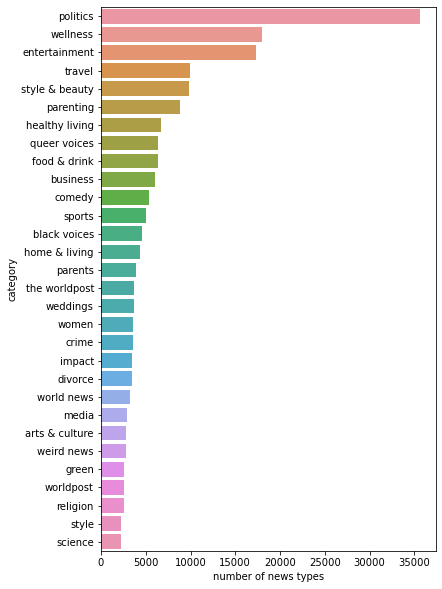

In [14]:
# top 30 locations in the dataset
top_30 = df.groupby(['category']).count().text.sort_values(ascending = False)[:30]

# plot the top 30

plt.figure(figsize = (6,10))
sns.barplot(x = top_30, y = top_30.index);
plt.xlabel('number of news types');


In [150]:
from sklearn.utils import resample
import pandas as pd

def make_resample(_df, column):

    dfs_r = {}
    dfs_c = {}
    bigger = 1000
    ignore = ""
    for c in _df[column].unique():
        dfs_c[c] = _df[df[column] == c]
#         if dfs_c[c].shape[0] > bigger && bigger < 1000:
#             bigger = dfs_c[c].shape[0]
#             ignore = c

    for c in dfs_c:
#         if c == ignore:
#             continue
        dfs_r[c] = resample(dfs_c[c], 
                        replace=False,
                        n_samples=100,
                        random_state=1)
    return pd.concat([dfs_r[c] for c in dfs_r] )

In [151]:
df_balanced = make_resample(df,'category')

In [152]:
_df = df
df = df_balanced

Text(0.5, 0, 'number of news types')

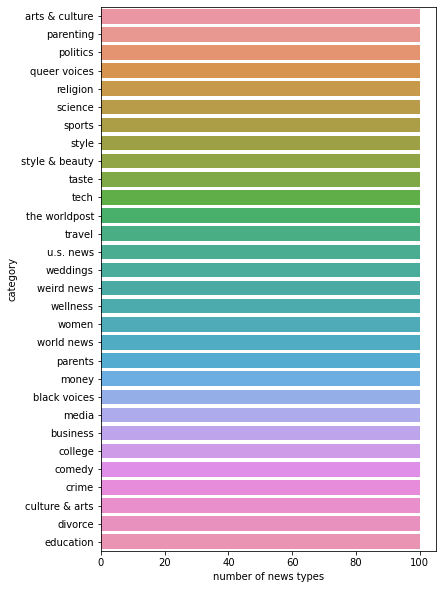

In [153]:
top_30 = df.groupby(['category']).count().text.sort_values(ascending = False)[:30]

# plot the top 30

plt.figure(figsize = (6,10))
sns.barplot(x = top_30, y = top_30.index);
plt.xlabel('number of news types')

In [154]:
df = df.reset_index()

ValueError: cannot insert level_0, already exists

# **BERT!**
Bidirectional Encoder Representations from Transformers

In [155]:
# !pip install tokenization

In [156]:
# !pip install bert-tensorflow


In [157]:
# Bert Tokenizer for all of them

# !wget https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py
# from bert.tokenization import FullTokenizer
# FullTokenizer = FullTokenizer


In [158]:
from transformers import BertTokenizer

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize a sentence
sentence = "Hello, how are you today?"
sent2 = "Fine thanks"
# tokens = tokenizer.encode_plus(['[CLS]'] + tokenizer.tokenize(sentence) + ['[SEP]'] + tokenizer.tokenize(sent2) + ['[SEP]']
#                                ,return_attention_mask = True,    max_length = 66, truncation=True, 
# )

tokens = tokenizer(sentence,sent2)


decoded = tokenizer.decode(tokens["input_ids"])
print(tokens["input_ids"])
print(tokens["attention_mask"])
print(tokens["token_type_ids"])
decoded

# Convert tokens to their corresponding IDs
# token_ids = tokenizer.convert_tokens_to_ids(tokens)
# token = tokenizer.encode(tokens)

# segment_ids = tokenizer.create_token_type_ids_from_sequences(token)
# attention_mask = tokenizer.create_mask(token)


# print(attention_mask)
# print(token_ids)
# print(segment_ids)
# print(token)

[101, 7592, 1010, 2129, 2024, 2017, 2651, 1029, 102, 2986, 4283, 102]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1]


'[CLS] hello, how are you today? [SEP] fine thanks [SEP]'

In [159]:
# ! pip install bert-tensorflow==1.0.1
num_samples = df.shape[0]
max_len = 200

ids = np.zeros((num_samples, max_len))
mask = np.zeros((num_samples, max_len))
tok_type = np.zeros((num_samples,max_len))

In [160]:
def tokenize_text(text1,text2):
    return tokenizer(text1,text2 ,padding = 'max_length',max_length = max_len)
    

encoded = df.apply(lambda x: tokenize_text(x.headline, x.short_description), axis=1)
df.head(2)

,level_0,index,headline,category,short_description,text
80,255,6495,richard bransons virgin galactic plans go public end 2019,u.s. news,"branson’s company racing blue origin, space business amazon.com inc founder jeff bezos, bring tourists space.","richard bransons virgin galactic plans go public end 2019 branson’s company racing blue origin, space business amazon.com inc founder jeff bezos, bring tourists space."
84,951,925,alex jones faces fines skipping sandy hook deposition,u.s. news,"penalties begin $25,000 per weekday beginning friday increase $25,000 per weekday appears deposition,","alex jones faces fines skipping sandy hook deposition penalties begin $25,000 per weekday beginning friday increase $25,000 per weekday appears deposition,"


In [161]:
encoded

80      [input_ids, token_type_ids, attention_mask]
84      [input_ids, token_type_ids, attention_mask]
33      [input_ids, token_type_ids, attention_mask]
81      [input_ids, token_type_ids, attention_mask]
93      [input_ids, token_type_ids, attention_mask]
                           ...                     
4075    [input_ids, token_type_ids, attention_mask]
4009    [input_ids, token_type_ids, attention_mask]
4072    [input_ids, token_type_ids, attention_mask]
4012    [input_ids, token_type_ids, attention_mask]
4037    [input_ids, token_type_ids, attention_mask]
Length: 4100, dtype: object

In [162]:
for i in range(num_samples):
    ids[i] =  encoded[i]['input_ids']
    mask[i] = encoded[i]['attention_mask']
    tok_type[i] = encoded[i]['token_type_ids']

### convert to tensor as the model is not fitting on ndarray

In [163]:
ids_ts = tf.convert_to_tensor(ids)
mask_ts = tf.convert_to_tensor(mask)
tok_type_ts = tf.convert_to_tensor(tok_type)



ids_ts = tf.cast(ids_ts, tf.int32)
mask_ts = tf.cast(mask_ts, tf.int32)
tok_type_ts = tf.cast(tok_type_ts, tf.int32)

In [164]:
ids_ts

<tf.Tensor: shape=(4100, 200), dtype=int32, numpy=
array([[  101,  4386, 21294, ...,     0,     0,     0],
       [  101,  8398,  3447, ...,     0,     0,     0],
       [  101,  3008, 11830, ...,     0,     0,     0],
       ...,
       [  101,  2034,  3116, ...,     0,     0,     0],
       [  101,  3841,  8500, ...,     0,     0,     0],
       [  101,  5002,  2758, ...,     0,     0,     0]])>

In [165]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

le = LabelEncoder()
labelEncode = le.fit(df["category"])
print(labelEncode.classes_)         #prints labels by order as fitted in encoder
label = labelEncode
labelEncode = le.fit_transform(df["category"])

print("LabelEncode")
print(labelEncode)

categorical_y = to_categorical(labelEncode)
print("\n To_Categorical one hot encode")
print(categorical_y)

['arts & culture' 'black voices' 'business' 'college' 'comedy' 'crime'
 'culture & arts' 'divorce' 'education' 'entertainment' 'environment'
 'fifty' 'food & drink' 'good news' 'green' 'healthy living'
 'home & living' 'impact' 'latino voices' 'media' 'money' 'parenting'
 'parents' 'politics' 'queer voices' 'religion' 'science' 'sports' 'style'
 'style & beauty' 'taste' 'tech' 'the worldpost' 'travel' 'u.s. news'
 'weddings' 'weird news' 'wellness' 'women' 'world news' 'worldpost']
LabelEncode
[34 34 34 ...  7  7  7]

 To_Categorical one hot encode
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [166]:
# df1 = df[['a', 'b']]

x = [ids,mask,tok_type]
# x = tf.transpose(x)
# x = encoded

In [167]:
from sklearn.model_selection import train_test_split
 
X1_train, X1_test, y_train, y_test = train_test_split(
    ids, categorical_y, test_size = 0.1, random_state = 2, stratify = categorical_y)


X2_train, X2_test, y_train, y_test = train_test_split( mask, categorical_y, test_size = 0.1, random_state = 2, stratify = categorical_y)

X3_train, X3_test, y_train, y_test = train_test_split(
        tok_type, categorical_y, test_size = 0.1, random_state = 2, stratify = categorical_y)




In [168]:
x_train = [X1_train,X2_train,X3_train]
x_test = [X1_test,X2_test,X3_test]

## Building a Bert Model

In [79]:
import bert
import tensorflow_hub as hub
from transformers import TFAutoModel

# bert = TFAutoModel.from_pretrained('bert-base-cased' ,trainable = True )
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1",
                            trainable=True)

In [169]:
bert_layer2 = hub.KerasLayer("https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/2",
                            trainable=True)

In [440]:
bert_layer3 = hub.KerasLayer("https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/2",
                            trainable=True)

In [174]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.utils import plot_model
from keras.losses import categorical_crossentropy
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from keras.utils import plot_model




input_word_ids = Input(shape = (max_len, ), dtype = tf.int32, name = 'input_word_ids')
input_mask = Input(shape = (max_len, ), dtype = tf.int32, name = 'input_mask')
segment_ids = Input(shape = (max_len, ), dtype = tf.int32,   name = 'input_type_ids')

input_bert = {
    'input_mask': input_mask,
     'input_type_ids': segment_ids,
     'input_word_ids' : input_word_ids
    
}

# pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
sequence_output = bert_layer2(input_bert)

# clf_output = sequence_output[:, 0, :]

x = sequence_output['default']
x = tf.keras.layers.Dense(60, activation='relu')(x)
# x = tf.keras.layers.Dropout(0.2)(x)

out = tf.keras.layers.Dense(y_test.shape[1], activation='softmax', name='outputs')(x)

model = Model(inputs = input_bert, outputs = out)
# model = Model(inputs = [input_word_ids, input_mask, segment_ids], outputs = out)

model.compile(tf.keras.optimizers.Adam(learning_rate=0.1), loss='categorical_crossentropy', metrics=['accuracy'])



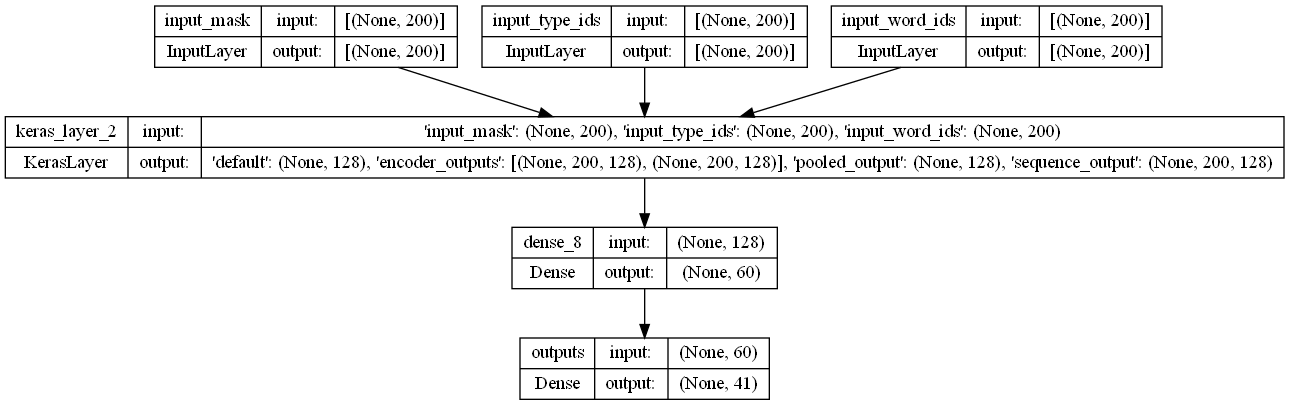

In [175]:
bert_model = model
plot_model(bert_model,show_shapes=True)

In [177]:
bert_history = bert_model.fit([x_train[1],x_train[2],x_train[0]],
                              y_train,
                              epochs=40,
                              batch_size=30,
                              validation_data=[[x_test[1],x_test[2],x_test[0]],y_test]
                             )


Epoch 1/40
123/123 [==============================] - 65s 532ms/step - loss: 3.7470 - accuracy: 0.0203 - val_loss: 3.7281 - val_accuracy: 0.0244
Epoch 2/40
123/123 [==============================] - 80s 654ms/step - loss: 3.7418 - accuracy: 0.0182 - val_loss: 3.7356 - val_accuracy: 0.0244
Epoch 3/40
123/123 [==============================] - 109s 886ms/step - loss: 3.7459 - accuracy: 0.0233 - val_loss: 3.7416 - val_accuracy: 0.0244
Epoch 4/40
123/123 [==============================] - 103s 835ms/step - loss: 3.7457 - accuracy: 0.0184 - val_loss: 3.7356 - val_accuracy: 0.0244
Epoch 5/40
123/123 [==============================] - 102s 829ms/step - loss: 3.7460 - accuracy: 0.0198 - val_loss: 3.7395 - val_accuracy: 0.0244
Epoch 6/40
123/123 [==============================] - 99s 802ms/step - loss: 3.7429 - accuracy: 0.0203 - val_loss: 3.7335 - val_accuracy: 0.0244
Epoch 7/40
 43/123 [=========>....................] - ETA: 1:03 - loss: 3.7466 - accuracy: 0.0202

KeyboardInterrupt: 

In [96]:
y_pred_test = bert_model.predict(x = [x_test[1],x_test[2],x_test[0]])

129/129 [==============================] - 37s 288ms/step


array([[0.02763289, 0.02314796, 0.02345162, ..., 0.02345989, 0.0251071 ,
        0.02241593],
       [0.02763289, 0.02314796, 0.02345162, ..., 0.02345989, 0.0251071 ,
        0.02241593],
       [0.02763289, 0.02314796, 0.02345162, ..., 0.02345989, 0.0251071 ,
        0.02241593],
       ...,
       [0.02763289, 0.02314796, 0.02345162, ..., 0.02345989, 0.0251071 ,
        0.02241593],
       [0.02763289, 0.02314796, 0.02345162, ..., 0.02345989, 0.0251071 ,
        0.02241593],
       [0.02763289, 0.02314796, 0.02345162, ..., 0.02345989, 0.0251071 ,
        0.02241593]], dtype=float32)

In [41]:
def build_model(bert_layer, max_len=512):
    input_word_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")
    
    pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    
    clf_output = sequence_output[:, 0, :]
    
    lay = tf.keras.layers.Dense(64, activation='relu')(clf_output)
    lay = tf.keras.layers.Dropout(0.2)(lay)
    lay = tf.keras.layers.Dense(32, activation='relu')(lay)
    lay = tf.keras.layers.Dropout(0.2)(lay)
    out = tf.keras.layers.Dense(5, activation='softmax')(lay)
    
    model = tf.keras.models.Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(tf.keras.optimizers.Adam(lr=2e-5), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model


In [42]:
model = build_model(bert_layer, max_len=x_train.shape[0])
model.summary()

NameError: name 'bert_layer' is not defined

In [ ]:
model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)


## **The BERT Model**

In [109]:
class TextClassifier:
    
    def __init__(self, tokenizer, bert_layer, max_len, lr = 0.0001,
                 epochs = 15, batch_size = 32,
                 activation = 'relu', optimizer = 'Adam',
                 beta_1=0.9, beta_2=0.999, epsilon=1e-07,
                 metrics = ['accuracy','recall','precision'], loss = 'categorical_crossentropy'):
        
        self.lr = lr
        self.epochs = epochs
        self.max_len = max_len
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.bert_layer = bert_layer
        

        self.activation = activation
        self.optimizer = optimizer
        
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.epsilon =epsilon
        
        self.metrics = metrics
        self.loss = loss

        
    def encode(self, texts):
        
        all_tokens = []
        masks = []
        segments = []
        
        for text in texts:
            
            tokenized = self.tokenizer.convert_tokens_to_ids(['[CLS]'] + self.tokenizer.tokenize(text) + ['[SEP]'])
            
            len_zeros = self.max_len - len(tokenized)
            
            
            padded = tokenized + [0] * len_zeros
            mask = [1] * len(tokenized) + [0] * len_zeros
            segment = [0] * self.max_len
            
            all_tokens.append(padded)
            masks.append(mask)
            segments.append(segment)
        
        return np.array(all_tokens), np.array(masks), np.array(segments)


    def make_model(self):
        
        # Shaping the inputs to our model
        
        input_ids = Input(shape = (self.max_len, ), dtype = tf.int32, name = 'input_ids')
        
        input_mask = Input(shape = (self.max_len, ), dtype = tf.int32, name = 'input_mask')
        
        segment_ids = Input(shape = (self.max_len, ), dtype = tf.int32,  name = 'segment_ids')

        
        pooled_output, sequence_output = bert_layer2([input_ids, input_mask, segment_ids] )



        clf_output = sequence_output[:, 0, :]
        
        
        out = tf.keras.layers.Dense(30, activation = self.activation)(clf_output)

        out = tf.keras.layers.Dense(1, activation = self.activation)(clf_output)
        
        
        model = Model(inputs = [input_ids, input_mask, segment_ids], outputs = out)
        
        # define the optimizer

        if self.optimizer is 'SGD':
            optimizer = SGD(learning_rate = self.lr)

        elif self.optimizer is 'Adam': 
            optimizer = Adam(learning_rate = self.lr, beta_1=self.beta_1, beta_2=self.beta_2, epsilon=self.epsilon)

        model.compile(loss = self.loss, optimizer = self.optimizer, metrics = [self.metrics])
        
        print('Model is compiled with {} optimizer'.format(self.optimizer))
        
        return model
    
    
    
    
    def train(self, x):    
        
        checkpoint = ModelCheckpoint('model.h5', monitor='val_loss',
                                     save_best_only=True)
            
        
        model = self.make_model()
        
        X = self.encode(x['cleaned_text'])
        Y = x['target']
        
        model.fit(X, Y, shuffle = True, validation_split = 0.2, 
                  batch_size=self.batch_size, epochs = self.epochs,
                  callbacks=[checkpoint])
                
        print('Model is fit!')
        
            
    def predict(self, x):
        
        X_test_encoded = self.encode(x['cleaned_text'])
        best_model = tf.keras.models.load_model('model.h5',custom_objects={'KerasLayer':hub.KerasLayer})
        y_pred = best_model.predict(X_test_encoded)
        
        
        return y_pred


<>:79: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:82: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:79: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:82: SyntaxWarning: "is" with a literal. Did you mean "=="?
C:\Users\ALI\AppData\Local\Temp\ipykernel_22916\2247014216.py:79: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if self.optimizer is 'SGD':
C:\Users\ALI\AppData\Local\Temp\ipykernel_22916\2247014216.py:82: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif self.optimizer is 'Adam':


In [110]:
classifier = TextClassifier(tokenizer = tokenizer, bert_layer = bert_layer2,
                              max_len = max_len, lr = 0.001,
                              epochs = 7,  activation = 'relu',
                              batch_size = 32,optimizer = 'SGD',
                              beta_1=0.9, beta_2=0.999, epsilon=1e-07)

In [111]:
classifier.train([df['headline'],categorical_y])

C:\Users\ALI\AppData\Local\Temp\ipykernel_22916\2247014216.py:79: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if self.optimizer is 'SGD':
C:\Users\ALI\AppData\Local\Temp\ipykernel_22916\2247014216.py:82: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif self.optimizer is 'Adam':
C:\Users\ALI\AppData\Local\Temp\ipykernel_22916\2247014216.py:79: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if self.optimizer is 'SGD':
C:\Users\ALI\AppData\Local\Temp\ipykernel_22916\2247014216.py:82: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif self.optimizer is 'Adam':
C:\Users\ALI\AppData\Local\Temp\ipykernel_22916\2247014216.py:79: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if self.optimizer is 'SGD':
C:\Users\ALI\AppData\Local\Temp\ipykernel_22916\2247014216.py:82: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif self.optimizer is 'Adam':
C:\Users\ALI\AppData\Local\Temp\ipykernel_22916\2247014216.py:79: SyntaxWarning: "is"

ValueError: Exception encountered when calling layer "keras_layer" (type KerasLayer).

in user code:

    File "C:\Users\ALI\anaconda3\lib\site-packages\tensorflow_hub\keras_layer.py", line 237, in call  *
        result = smart_cond.smart_cond(training,

    ValueError: Could not find matching concrete function to call loaded from the SavedModel. Got:
      Positional arguments (3 total):
        * [<tf.Tensor 'inputs:0' shape=(None, 350) dtype=int32>,
     <tf.Tensor 'inputs_1:0' shape=(None, 350) dtype=int32>,
     <tf.Tensor 'inputs_2:0' shape=(None, 350) dtype=int32>]
        * False
        * None
      Keyword arguments: {}
    
     Expected these arguments to match one of the following 4 option(s):
    
    Option 1:
      Positional arguments (3 total):
        * {'input_mask': TensorSpec(shape=(None, None), dtype=tf.int32, name='input_mask'),
     'input_type_ids': TensorSpec(shape=(None, None), dtype=tf.int32, name='input_type_ids'),
     'input_word_ids': TensorSpec(shape=(None, None), dtype=tf.int32, name='input_word_ids')}
        * False
        * None
      Keyword arguments: {}
    
    Option 2:
      Positional arguments (3 total):
        * {'input_mask': TensorSpec(shape=(None, None), dtype=tf.int32, name='inputs/input_mask'),
     'input_type_ids': TensorSpec(shape=(None, None), dtype=tf.int32, name='inputs/input_type_ids'),
     'input_word_ids': TensorSpec(shape=(None, None), dtype=tf.int32, name='inputs/input_word_ids')}
        * False
        * None
      Keyword arguments: {}
    
    Option 3:
      Positional arguments (3 total):
        * {'input_mask': TensorSpec(shape=(None, None), dtype=tf.int32, name='inputs/input_mask'),
     'input_type_ids': TensorSpec(shape=(None, None), dtype=tf.int32, name='inputs/input_type_ids'),
     'input_word_ids': TensorSpec(shape=(None, None), dtype=tf.int32, name='inputs/input_word_ids')}
        * True
        * None
      Keyword arguments: {}
    
    Option 4:
      Positional arguments (3 total):
        * {'input_mask': TensorSpec(shape=(None, None), dtype=tf.int32, name='input_mask'),
     'input_type_ids': TensorSpec(shape=(None, None), dtype=tf.int32, name='input_type_ids'),
     'input_word_ids': TensorSpec(shape=(None, None), dtype=tf.int32, name='input_word_ids')}
        * True
        * None
      Keyword arguments: {}


Call arguments received by layer "keras_layer" (type KerasLayer):
  • inputs=['tf.Tensor(shape=(None, 350), dtype=int32)', 'tf.Tensor(shape=(None, 350), dtype=int32)', 'tf.Tensor(shape=(None, 350), dtype=int32)']
  • training=False

In [ ]:
# Optional
# Explore BERT's dictionary file
with open(vocabulary_file) as f:
    dic = f.readlines()
pd.Series(dic)[pd.Series(dic).str.contains('cru')]
#custom_objects={'KerasLayer':hub.KerasLayer}

# Testing your predictions:

perfect_submission = pd.read_csv('Kaggle_NLP_competition/perfect_submission.csv')

y_pred = np.round(classifier.predict(test_cleaned))
print('The score of prediction: ', sklearn.metrics.f1_score(perfection.target, y_pred, average = 'micro'))